# Final project data analysis

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pandas.plotting import lag_plot
from datetime import datetime
from IPython.display import Image

## Libraries Versions:

# Importing treated data

In [2]:
historico = pd.read_csv('../../../../Projeto_final_IH/historico_all.csv')
proposta = pd.read_csv('../../../../Projeto_final_IH/itens_proposta.csv')

# Historic table

In [3]:
historico.head()

,RETIRADA,DATA_INICIO_LOC,TIPO_EQPTO,ativo
0,2011-06-30,2011-06-29,13,sim
1,2011-06-30,2011-06-29,6,sim
2,2011-06-30,2011-06-29,6,sim
3,2011-07-05,2011-07-02,13,sim
4,2011-07-05,2011-07-02,1,sim


## Checking Missing Valuers

In [4]:
historico.isna().mean()

RETIRADA           0.0
DATA_INICIO_LOC    0.0
TIPO_EQPTO         0.0
ativo              0.0
dtype: float64

## Transforming 'data' column into date type

In [5]:
historico.RETIRADA = pd.to_datetime(historico.RETIRADA)
historico.DATA_INICIO_LOC = pd.to_datetime(historico.DATA_INICIO_LOC)

## Dropping lines where withdrawal date is before than starting lease's date

It's probably a system error for later verification

In [6]:
historico[historico.RETIRADA<historico.DATA_INICIO_LOC]

,RETIRADA,DATA_INICIO_LOC,TIPO_EQPTO,ativo
197,2011-12-13,2011-12-14,6,sim
198,2011-12-13,2011-12-14,6,sim
205,2011-12-13,2011-12-14,1,sim
206,2011-12-13,2011-12-14,10,
207,2011-12-13,2011-12-14,13,sim
...,...,...,...,...
24042,2018-11-28,2018-11-29,2,sim
24056,2019-04-26,2019-04-30,2,sim
24252,2019-11-04,2019-11-05,2,sim
24253,2019-11-04,2019-11-05,2,sim


**Extraction rows index to drop**

In [7]:
index_list = historico[historico.RETIRADA<historico.DATA_INICIO_LOC].index

**Droping rows**

In [8]:
historico.drop(index=index_list,inplace=True)

## Creating column for leasing duration

In [9]:
historico['duracao'] = (historico.RETIRADA- historico.DATA_INICIO_LOC).dt.days
historico

,RETIRADA,DATA_INICIO_LOC,TIPO_EQPTO,ativo,duracao
0,2011-06-30,2011-06-29,13,sim,1
1,2011-06-30,2011-06-29,6,sim,1
2,2011-06-30,2011-06-29,6,sim,1
3,2011-07-05,2011-07-02,13,sim,3
4,2011-07-05,2011-07-02,1,sim,3
...,...,...,...,...,...
24345,2019-12-18,2019-12-06,2,sim,12
24346,2019-12-18,2019-12-06,2,sim,12
24347,2019-12-18,2019-12-06,2,sim,12
24348,2019-12-18,2019-12-06,2,sim,12


In [10]:
historico.duracao.value_counts()

1       5709
0       2548
2       1622
3       1503
4        924
        ... 
167        1
343        1
535        1
1063       1
927        1
Name: duracao, Length: 408, dtype: int64

**Was noticed when it is one day event it transform into 0**

* For this reason was created another column to verify the occupation that includes the beginning of rental and includes the withdraw day

In [11]:
historico['duracao_ocupacao'] = (historico.RETIRADA- historico.DATA_INICIO_LOC).dt.days+1
historico

,RETIRADA,DATA_INICIO_LOC,TIPO_EQPTO,ativo,duracao,duracao_ocupacao
0,2011-06-30,2011-06-29,13,sim,1,2
1,2011-06-30,2011-06-29,6,sim,1,2
2,2011-06-30,2011-06-29,6,sim,1,2
3,2011-07-05,2011-07-02,13,sim,3,4
4,2011-07-05,2011-07-02,1,sim,3,4
...,...,...,...,...,...,...
24345,2019-12-18,2019-12-06,2,sim,12,13
24346,2019-12-18,2019-12-06,2,sim,12,13
24347,2019-12-18,2019-12-06,2,sim,12,13
24348,2019-12-18,2019-12-06,2,sim,12,13


## Distribution

### First attempt

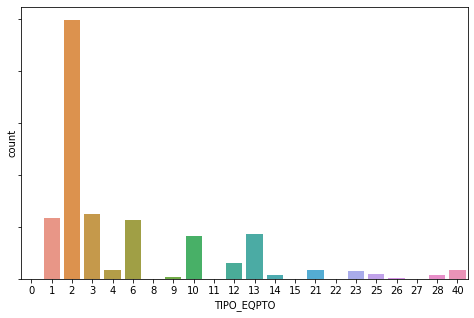

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(historico.TIPO_EQPTO)

plt.tick_params(
    axis='y',          
    which='both',      
    bottom=False,      
    right=False,         
    labelleft=False)
plt.show()

**This consider only the number of times each type of equipment was rented but do not consider for how long**

### Average rental time

In [13]:
historico.loc[:,['TIPO_EQPTO','duracao','duracao_ocupacao']].groupby(by='TIPO_EQPTO').agg([np.min, np.max, np.mean])

duracao                   duracao_ocupacao                  
              amin  amax        mean             amin  amax        mean
TIPO_EQPTO                                                             
0                3     3    3.000000                4     4    4.000000
1                0   837    2.412978                1   838    3.412978
2                0  1470   47.874485                1  1471   48.874485
3                0  1361   87.546289                1  1362   88.546289
4                0  1361   47.295858                1  1362   48.295858
6                0    38    1.103815                1    39    2.103815
8               34  1063  548.500000               35  1064  549.500000
9                0    17    2.127273                1    18    3.127273
10               0    38    1.545891                1    39    2.545891
11               1    14    3.500000                2    15    4.500000
12               0    49    1.919192                1    50    2.919192
13               0    41    1.505559                1    42    2.505559
14               0    28    1.921429                1    29    2.921429
15               0     1    0.125000                1     2    1.125000
21               0   511   32.752161                1   512   33.752161
22              16   213   33.800000               17   214   34.800000
23               0   277   36.710526                1   278   37.710526
25               0   217   31.115607                1   218   32.115607
26               1    18    7.038462                2    19    8.038462
27               1     7    2.000000                2     8    3.000000
28               0   252   19.484848                1   253   20.484848
40               0   952   98.446686                1   953   99.446686

# Creating table 'df_giro' with equipment rental per day

In [14]:
def base_dataframe(df,split_col):
    """
    This function gets min and max date and create one empty Dataframe for the splitting column
    """
    #getting minimal date
    min_date = df.select_dtypes(include=['datetime64']).agg({min,max}).loc['min',:].min().date()
    #getting max date
    max_date = df.select_dtypes(include=['datetime64']).agg({min,max}).loc['max',:].max().date()
    #Creating empty Dataframe
    df_return = pd.DataFrame(pd.date_range(start=min_date, end=max_date).date,columns=['data'])
    
    #creting a list of unique items values and sorting  
    items_lst = df[split_col].unique()
    items_lst.sort()
    # creating one column for each item with 0 value
    for item in items_lst:
        df_return[item]=0
    
    df_return = df_return.set_index('data')
    return df_return

In [15]:
base_dataframe(historico,'TIPO_EQPTO')

,0,1,2,3,4,6,8,9,10,11,...,14,15,21,22,23,25,26,27,28,40
data,,,,,,,,,,,,,,,,,,,,,
2007-09-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def insert_values(df,split_col):
    """
    This function insert rental values for each item por for spliting column
    """
    #creating empty df with min and max dates
    df_return = base_dataframe(df,split_col)
    
    #looping through each item name in splitted column list. ex: Getting all index numbers for item 'A'
    for item in tqdm(df[split_col].unique()):

        #looping through index for each item name in main dataframe
        for index in df[df[split_col]==item].index:

            #looping through range date of each line - because i've got starting column and ending column
            for dia in pd.date_range(start=df[df[split_col]==item].loc[index,'DATA_INICIO_LOC'], end=df[df[split_col]==item].loc[index,'RETIRADA']):

                #adding one for each day
                df_return.loc[dia.date(),item] += 1 
    return df_return

In [17]:
df_giro = insert_values(historico,'TIPO_EQPTO')

In [18]:
df_giro

,0,1,2,3,4,6,8,9,10,11,...,14,15,21,22,23,25,26,27,28,40
data,,,,,,,,,,,,,,,,,,,,,
2007-09-01,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-02,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-03,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-04,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-05,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,0,0,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-16,0,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-17,0,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Distribution graphs

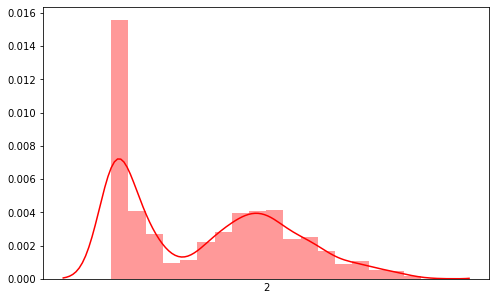

In [19]:
plt.figure(figsize=(8,5))
sns.distplot(df_giro[2], color='red')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

**There are a large number of days when the item 2 is in stock (around 0) and another distribution close to 170 rented item 2**

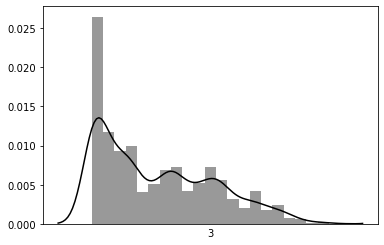

In [20]:
sns.distplot(df_giro[3], color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

**There are a large number of days when the item 3 is in stock (around 0) and two others distributions one aorund 60 and a lower one around 90**

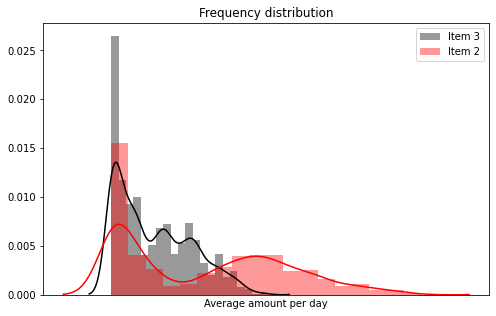

In [21]:
plt.figure(figsize=(8,5))
sns.distplot(df_giro[3], color='black',label='Item 3')
sns.distplot(df_giro[2], color='red',label='Item 2')
plt.legend()
plt.title('Frequency distribution')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.xlabel('Average amount per day')
plt.show()

From this camparison:
* Item 2 is more stable over time than item 3
* More items 3, on average, are  in stock than item 2 in relation their respective total

## Graphs of equipment rental per day

In [22]:
def conv_str_dat(string):
    """
    Converts string to date
    """
    return datetime.strptime(string, '%Y-%m-%d').date()

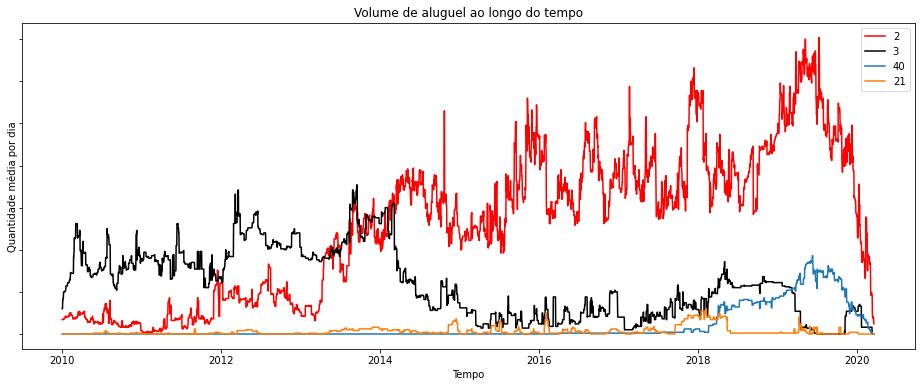

In [23]:
plt.figure(figsize=(16,6))
df_2 = df_giro[2].reset_index()[df_giro[2].reset_index().data>conv_str_dat('2010-01-01')]
df_3 = df_giro[3].reset_index()[df_giro[2].reset_index().data>conv_str_dat('2010-01-01')]
df_40 = df_giro[40].reset_index()[df_giro[2].reset_index().data>conv_str_dat('2010-01-01')]
df_21 = df_giro[21].reset_index()[df_giro[2].reset_index().data>conv_str_dat('2010-01-01')]

sns.lineplot(x='data',y=2,data=df_2,label='2',color ='red')
sns.lineplot(x='data',y=3,data=df_3,label='3',color ='black')
sns.lineplot(x='data',y=40,data=df_40,label='40')
sns.lineplot(x='data',y=21,data=df_21,label='21')

plt.title('Volume de aluguel ao longo do tempo')


plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)




plt.ylabel('Quantidade média por dia')
plt.xlabel('Tempo')
plt.show()

# Equipment - Time Series Analysis

In [24]:
#Assigning frequency to the index
df_giro.index = pd.DatetimeIndex(df_giro.index, freq='D')

## Relationship between current day's rent and the previous one

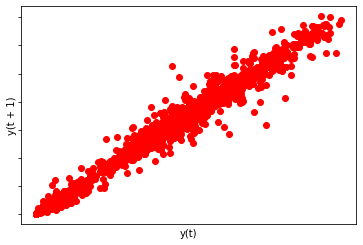

In [25]:
lag_plot(df_giro[2], c='red')


plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)
plt.show()

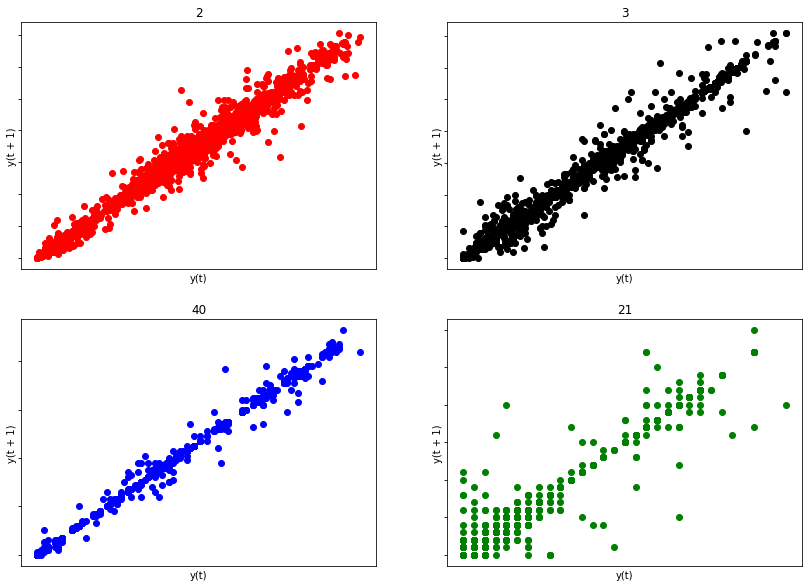

In [26]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)
plt.ylabel('y(t+1)')
plt.xlabel('y(t)')
plt.title('2')
lag_plot(df_giro[2], c='red')

plt.subplot(222)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)
plt.ylabel('y(t+1)')
plt.xlabel('y(t)')
plt.title('3')
lag_plot(df_giro[3], c='black')

plt.subplot(223)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)
plt.ylabel('y(t+1)')
plt.xlabel('y(t)')
plt.title('40')
lag_plot(df_giro[40], c='blue')

plt.subplot(224)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)
plt.ylabel('y(t+1)')
plt.xlabel('y(t)')
plt.title('21')
lag_plot(df_giro[21], c='green')

plt.show()

**Some itens are stronger than others**

## Decomposition

Decomposing a time series into:
    
- Mean
- Trends
- Seasonal Effects
- Noise

## Item 2 decompostion

**Creating each result inside a dataframe for better manipulation**

In [27]:
res = sm.tsa.seasonal_decompose(df_giro[2], period=360)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

In [28]:
df_res_02 = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})

In [29]:
df_res_02

,observed,trend,seasonal,residual
data,,,,
2007-09-01,0.0,NaN,-10.538664,NaN
2007-09-02,0.0,NaN,-11.405215,NaN
2007-09-03,0.0,NaN,-13.104983,NaN
2007-09-04,0.0,NaN,-10.971419,NaN
2007-09-05,0.0,NaN,-10.837507,NaN
...,...,...,...,...
2020-03-15,19.0,NaN,-0.226048,NaN
2020-03-16,20.0,NaN,1.633674,NaN
2020-03-17,20.0,NaN,2.911336,NaN


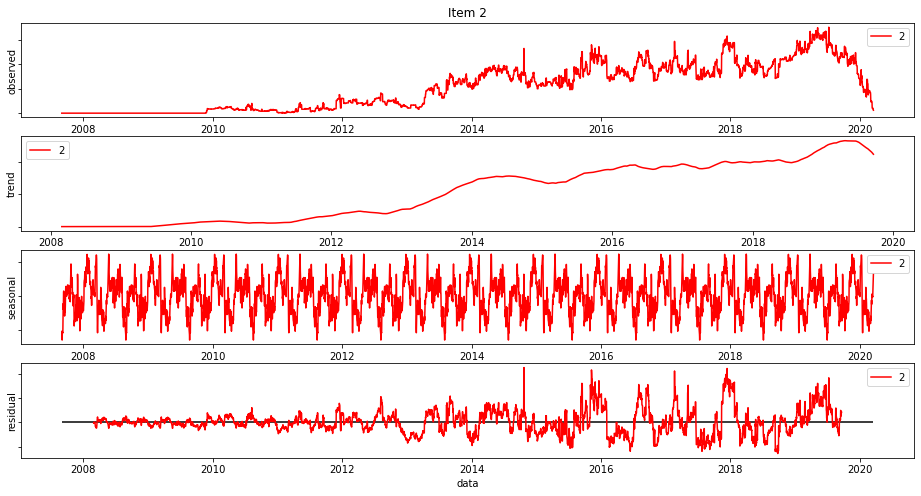

In [31]:
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res_02.index,y='observed',data=df_res_02,label='2',color ='red')
plt.title('Item 2')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res_02.index,y='trend',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res_02.index,y='seasonal',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res_02.index,y='residual',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res_02.index.min(),xmax=df_res_02.index.max())
plt.show()

## Item 3 Decomposition

In [32]:
res = sm.tsa.seasonal_decompose(df_giro[3], period=360)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

In [33]:
df_res_03 = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})

In [34]:
df_res_03

,observed,trend,seasonal,residual
data,,,,
2007-09-01,0.0,NaN,-6.279765,NaN
2007-09-02,0.0,NaN,-6.786015,NaN
2007-09-03,0.0,NaN,-5.958932,NaN
2007-09-04,0.0,NaN,-6.465182,NaN
2007-09-05,0.0,NaN,-6.471432,NaN
...,...,...,...,...
2020-03-15,0.0,NaN,-3.708584,NaN
2020-03-16,0.0,NaN,-3.291918,NaN
2020-03-17,0.0,NaN,-4.458584,NaN


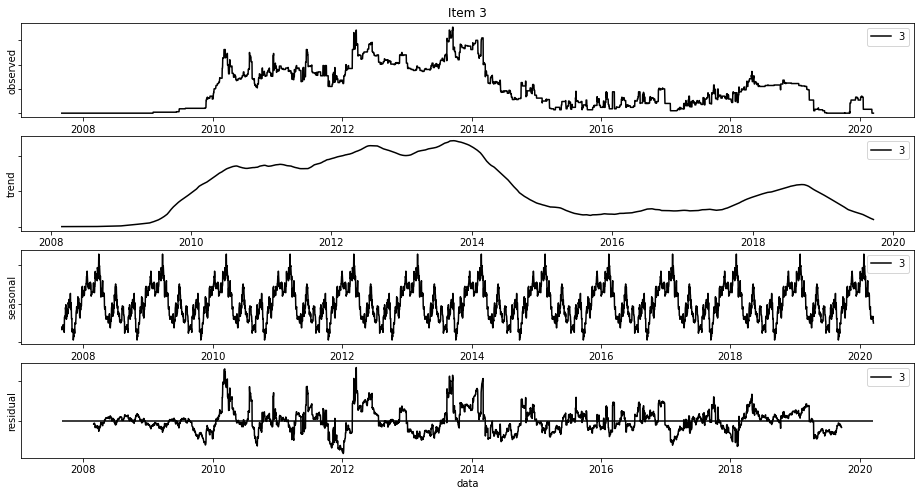

In [41]:
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res_03.index,y='observed',data=df_res_03,label='3',color ='black')
plt.title('Item 3')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res_03.index,y='trend',data=df_res_03,label='3',color ='black')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res_03.index,y='seasonal',data=df_res_03,label='3',color ='black')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res_03.index,y='residual',data=df_res_03,label='3',color ='black')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res_03.index.min(),xmax=df_res_03.index.max())
plt.show()

## Checking stationarity

In [42]:
adfuller(df_giro[2], autolag='AIC', regression='ct')

(-2.234912841990861,
 0.4702306332777901,
 28,
 4555,
 {'1%': -3.9607588798067406,
  '5%': -3.4114542998772825,
  '10%': -3.127617829367532},
 31945.014662646823)

I can't reject the fact that item 2 timeseries is NOT stationary.

In [43]:
adfuller(df_giro[3], autolag='AIC', regression='ct')

(-2.1999016609263946,
 0.48990586791813584,
 23,
 4560,
 {'1%': -3.9607566975136557,
  '5%': -3.4114532420528643,
  '10%': -3.1276172065398917},
 25200.06315720771)

I can't reject the fact that item 3 timeseries is NOT stationary.

In [44]:
adfuller(df_giro[23], autolag='AIC', regression='ct')

(-6.017870879013976,
 2.014707037785618e-06,
 32,
 4551,
 {'1%': -3.960760629096135,
  '5%': -3.4114551478111284,
  '10%': -3.12761832861533},
 15083.674545453687)

I can reject the fact that item 23 timeseries is NOT stationary because it's p value is under 0.05%

# Prophet

## Creating function to predict each equipment predict over time

In [45]:
def pred_equip_demand(df,data_col='data',period=30):
    """
    This function gets df_giro and return a dictionary with the prediction of equipment demand.
    It uses prophet method for each kind o equipment and for all equipments.
    For each equipment's dict, it return prophet's df, model, future, forecast, forecast plot and components plot 
    data_col must be int the index
    period: number of days predict in the future
    
    """
    from fbprophet import Prophet
    from tqdm.auto import tqdm
    #create main dict
    equip_dict ={}

    #looping through each column (equipment)
    for equip in tqdm(df.columns):
        
        #create one dict for each equipment
        equip_dict[equip]={}
        
        #transform 'data' into 'ds'
        df_prophet= df[[equip]].reset_index().rename({data_col:'ds',equip:'y'},axis=1)
        
        #starting prophet model
        model = Prophet(growth='linear')
        model.fit(df_prophet)
        
        #creating futere days to predict
        future = model.make_future_dataframe(periods=period,freq='D')
        #predicting
        forecast = model.predict(future)
        #forecast plot
        forecast_plot = model.plot(forecast)
        #components plot
        components_plot_forecast = model.plot_components(forecast)

        #creating each dict for each equipment
        equip_dict[equip]['df'] = df_prophet
        equip_dict[equip]['model'] = model
        equip_dict[equip]['future'] = future
        equip_dict[equip]['forecast'] =forecast
        equip_dict[equip]['forecast_plot'] = forecast_plot
        equip_dict[equip]['components_plot_forecast'] = components_plot_forecast
    
    #creatting dict for the sum of all equipments
    equip_dict['all_equip']={}
    
    #summing all columns
    df = pd.DataFrame(df.sum(axis=1),columns=['all_equip'])
    #transform 'data' into 'ds'
    df_prophet= df[['all_equip']].reset_index().rename({'data':'ds','all_equip':'y'},axis=1)
        
    #starting prophet model
    model = Prophet(growth='linear')
    model.fit(df_prophet)
        
    #creating futere days to predict
    future = model.make_future_dataframe(periods=period,freq='D')
    #predicting
    forecast = model.predict(future)
    #forecast plot
    forecast_plot = model.plot(forecast)
    #components plot
    components_plot_forecast = model.plot_components(forecast)

    #creating each dict for all equipments
    equip_dict['all_equip']['df'] = df_prophet
    equip_dict['all_equip']['model'] = model
    equip_dict['all_equip']['future'] = future
    equip_dict['all_equip']['forecast'] =forecast
    equip_dict['all_equip']['forecast_plot'] = forecast_plot
    equip_dict['all_equip']['components_plot_forecast'] = components_plot_forecast
    
    return equip_dict

In [48]:
#this code was run but to load on github it was hidden
#all_prophets = pred_equip_demand(df_giro)

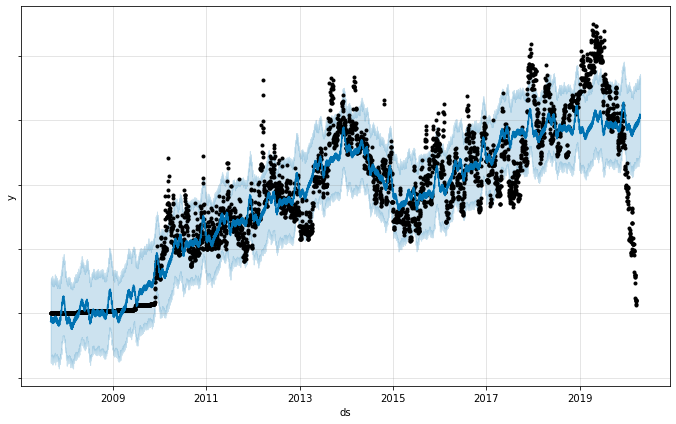

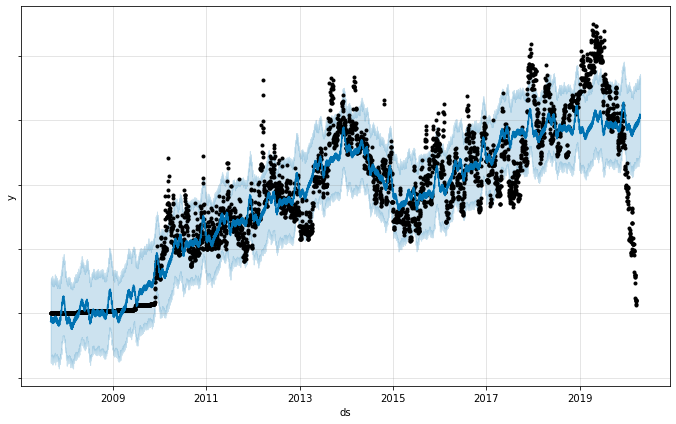

In [49]:
fig=plt.figure(figsize=(9.5,6)) #same default size as prophet
ax=fig.add_subplot(1,1,1)
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
all_prophets['all_equip']['model'].plot(all_prophets['all_equip']['forecast'],ax=ax)

## prophet plots

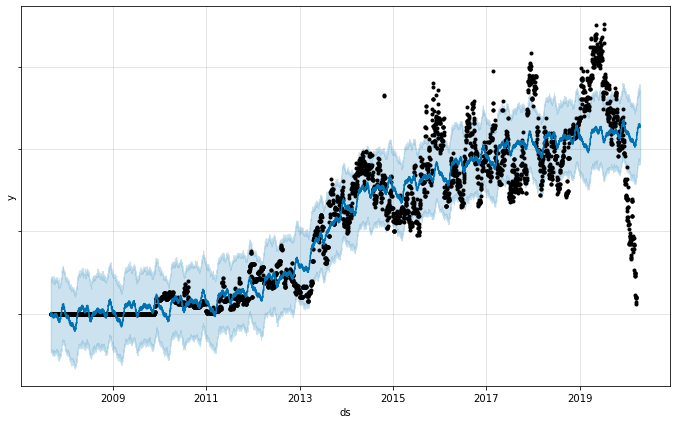

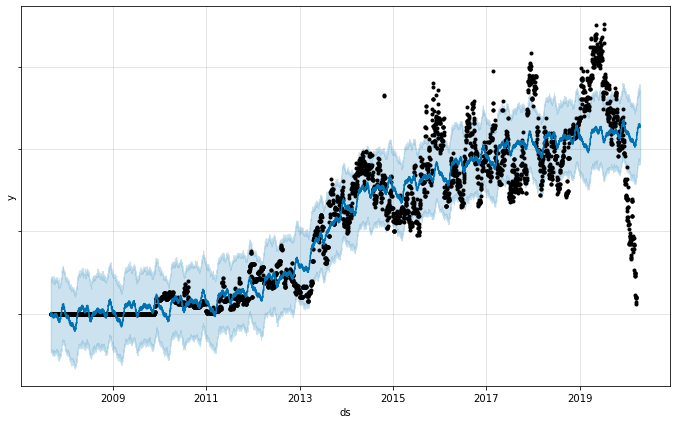

In [50]:
fig=plt.figure(figsize=(9.5,6)) #same default size as prophet
ax=fig.add_subplot(1,1,1)
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
all_prophets[2]['model'].plot(all_prophets[2]['forecast'],ax=ax)

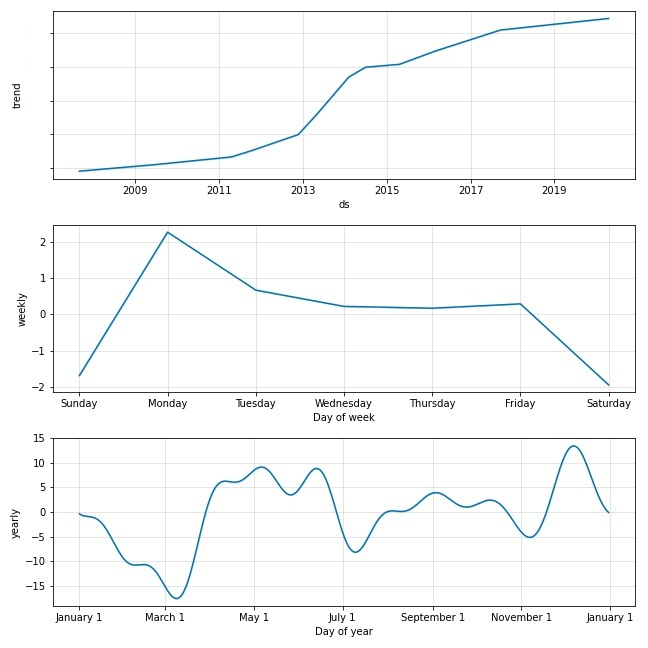

In [51]:
#this plot was saved into a image to remove the trend y axis values
#all_prophets[2]['components_plot_forecast'].savefig('./components_plot_forecast_item_2.jpg')
Image(filename='./components_plot_forecast_item_2.jpg') 

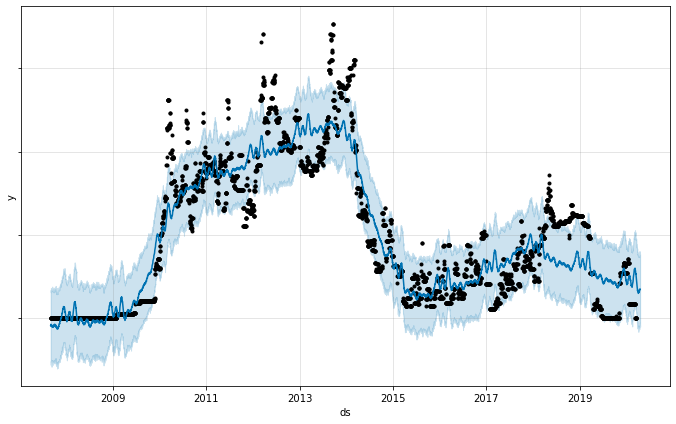

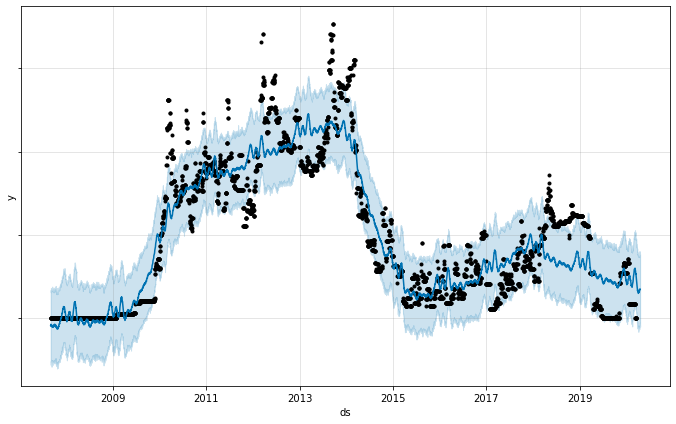

In [52]:
fig=plt.figure(figsize=(9.5,6)) #same default size as prophet
ax=fig.add_subplot(1,1,1)
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
all_prophets[3]['model'].plot(all_prophets[3]['forecast'],ax=ax)

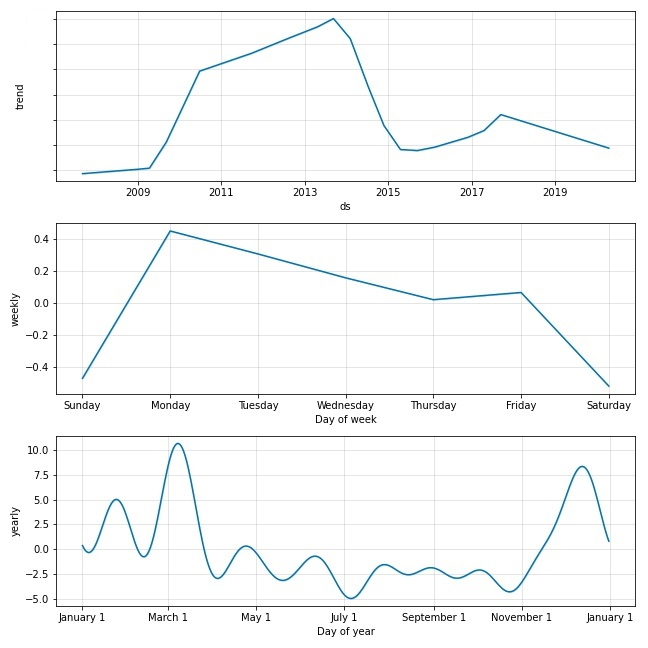

In [53]:
#this plot was saved into a image to remove the trend y axis values
#all_prophets[3]['components_plot_forecast'].savefig('./components_plot_forecast_item_3.jpg')
Image(filename='./components_plot_forecast_item_3.jpg') 